In [151]:
import numpy as np
def cosBell(x, alpha=0, beta=0.5):
    "Function defining a cosine bell as a function of position, x"
    "between alpha and beta with default parameters 0, 0.5"
### The lambda keyword lets you define a function in one line       ###
    width = beta - alpha
    bell = lambda x: 0.5*(1 - np.cos(2*np.pi*(x-alpha)/width))
### chooses bell(x) where condition is true, else chooses zeros     ###
    return np.where((x<beta) & (x>=alpha), bell(x), 0.)



In [159]:
def picard_method(X, nx, nt, Tfinal, u, mu, theta):
## Parameters
    
    dx = (1-0)/(nx-1) ##
    dt = (Tfinal-0)/(nt-1)
    C = u*dt/(2*dx)
    D = mu*dt/(dx**2)
    a_1 = dx**2/(2*mu)
    a_2 = 2*mu/(u**2)
    
    
    print("theta=",theta)
    if theta<0.5:
        print("explicit")
        if a_1<dt:
            print("error timestep too big")
        if a_2<dt:
            print("error timestep too big")
        print("dt=",dt,"a_1=",a_1,"a_2=",a_2)
        
    if theta == 0.5:
        print("2nd order", "implicit")
    if theta >0.5:
        print("implicit")

  
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])
    for i in range(0,nt-1):
        
        for j in range(0,nx): 
            beta[j] = X[i,j]\
            - C*(1-theta)*X[i,j]*(X[i,(j+1)%nx] - X[i,(j-1)%nx])\
            + (D)*(1-theta)*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
        
        for p in range(0,nx):
            A[p,(p+1)%nx] =  theta*C*X[i,p] - theta*D
            A[p,(p-1)%nx] = -theta*C*X[i,p] - theta*D
            A[p,p] = 1 + 2*theta*D
        
        X[i+1,:] = scipy.linalg.solve(A, beta)
    return X

In [160]:
def timestepping_ftcs(X , c, d, nx, nt, dx, dt, u, mu):
    ###Conditions for explicit timestep 
    a_1 = dx**2/(2*mu)
    a_2 = 2*mu/(u**2)
    print("dt= ",dt,"a_1=",a_1,"a_2=",a_2)
    if a_1<dt:
        print("error timestep too big")
    if a_2<dt:
        print("error timestep too big")
        
    ###The computation    
    for i in range(0,nt-1): ##i+1
        for j in range(0,nx):  
            X[i+1,j] = X[i,j] - c*X[i,j]*(X[i,(j+1)%nx] - X[i,(j-1)%nx])/2 + d*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
    return X


In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def newton_method(X, nx, nt, Tfinal, u, mu, theta=0.5):

    
    ##derived constants

    dx = (1-0)/(nx-1) ##
    dt = (Tfinal-0)/(nt-1)
    ## Parameters
    C = u*dt/(2*dx)
    D = mu*dt/(dx**2)
    ##

    ##Construction of the vector per timestep ie beta note for inversion we only want the 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])





    
    for i in range(0,nt-1):### time loop 
        ## first initialise w^0 = phi^n
        for j in range(0,nx): 
            w[j] = X[i,j]

        ### Construct the newton loop
        tol = 10**(-13)## extreeme accuracy can be imposed
        err  = 2*tol
        while (err>tol): ## eventually replace with while loop and stopping criterion
        ### create A_k, beta_k
            ##Create beta^k
            for q in range(0,nx): 
                beta[q] = X[i,q] - C*(1-theta)*X[i,q]*(X[i,(q+1)%nx] - X[i,(q-1)%nx]) + (D)*(1-theta)*(X[i,(q-1)%nx]-2*X[i,q]+X[i,(q+1)%nx]) \
                -w[q] - C*theta*w[q]*(w[(q+1)%nx]-w[(q-1)%nx]) + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ##Create A^k ###what is the j doing here
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[p])-(theta*D))
            for p in range(0,nx-1):
                A[p,p+1] = ((theta*C*w[p])-(theta*D))
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
            
            
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,1)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
   
        for j in range(0,nx):
            X[i+1,j] = w[j]


    print("theta=", theta)
    return X 
    



In [162]:
import numpy as np
import matplotlib.pyplot as plt

def Main(nx ,nt ,Tfinal ,u ,mu, method):
    print("nx,nt,Tfinal ,u ,mu, method")
##derived constants
    x = np.linspace(0,1,nx)
    dx = (1-0)/(nx-1) ##
    t = np.linspace(0,Tfinal,nt)
    dt = (Tfinal-0)/(nt-1)
    c = u*(dt/dx)
    d = mu*(dt*u/(dx**2))
    
##**Creating the structure**## 
##**Each row contains a timestep**##
    X = np.zeros( [nt,nx] )
    

        
### Initialisation of BC
    X[0,:] = cosBell(x, 0, 0.75)

### Timestepping the whole scheme 
    if method == "ftcs":
        timestepping_ftcs(X , c, d, nx, nt, dx, dt, u, mu)
    if method == "newton":
        newton_method(X, nx, nt, Tfinal, u, mu, theta=0.5)
    if method == "picard":
        picard_method(X, nx, nt, Tfinal, u, mu, theta=0)
##Extraction of time steps
    cmap = plt.get_cmap('jet_r')
    N = 200   
    for i in range(0,nt,1):
        y = X[i,:]
        color = cmap(float(i)/N)
        lw = 2.5 if i==0 else 1
        plt.plot(x, y, c=color, lw=lw, zorder=-i)
        



nx,nt,Tfinal ,u ,mu, method
theta= 0
explicit
dt= 0.02 a_1= 0.12500000000000003 a_2= 0.02


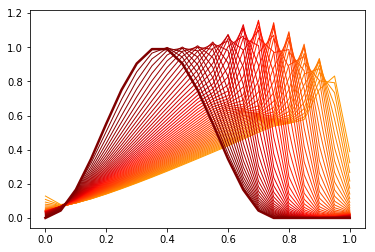

In [163]:
Main(21,51,1,1,0.01,"picard")
### spurious behaviour for implicit method on picards method

## this is because the implicit method introduces stability on a approximation of the equations

nx,nt,Tfinal ,u ,mu, method
dt=  0.02 a_1= 0.12500000000000003 a_2= 0.02


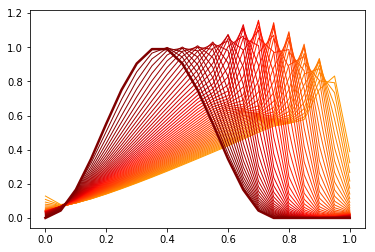

In [164]:
Main(21,51,1,1,0.01,"ftcs")

nx,nt,Tfinal ,u ,mu, method
theta= 0.5


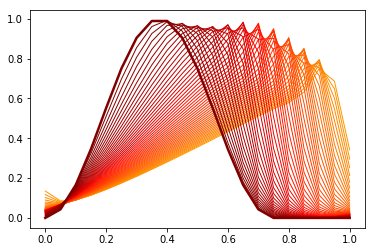

In [165]:
Main(21,51,1,1,0.01,"newton")